# Молекула H2

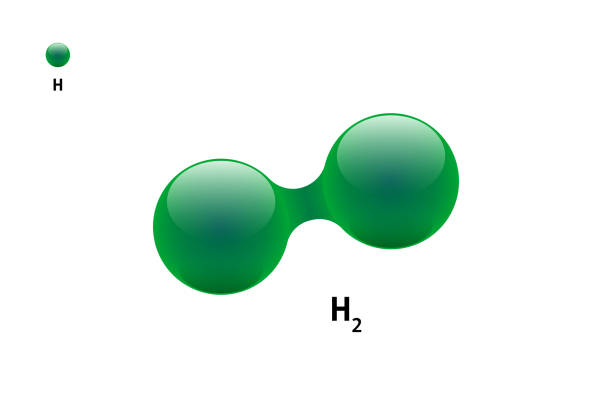
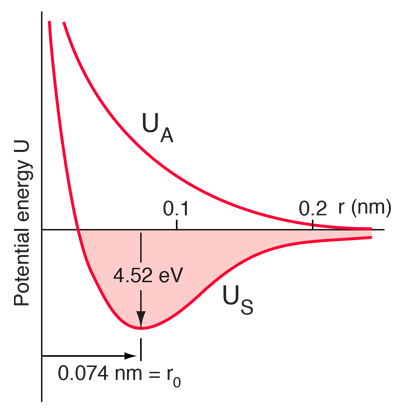

## Хімічна точність

У квантовій хімії часто говорять про **хімічну точність** — це відхилення енергії не більше ніж  

$$
1 \ \text{kcal/mol} \;\; \approx \; 0.0016\ \text{a.u.}
$$

Така точність вважається достатньою, щоб правильно передбачати більшість хімічних властивостей:  
- стабільність ізомерів,  
- енергії реакцій,  
- бар’єри переходів.  

Coupled Clusters (наприклад, CCSD(T)) зазвичай досягають хімічної точності для малих і середніх молекул.


## Експериментальні дані

| Параметр                       | Значення         | Одиниці     |
|--------------------------------|------------------|-------------|
| Рівноважна довжина зв'язку     | 0.741            | Å           |
| Енергія дисоціації D₀ (0 K)    | 0.166            | a.u.        |



# Розрахунки

In [1]:
from pyscf import gto, scf, cc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
basis = 'cc-PVDZ'

In [3]:
# дрібний крок біля мінімуму
R1 = np.arange(0.25, 1.25, 0.05)  # щільна сітка

# великий крок далеко від мінімуму
R2 = np.arange(1.25, 5.0, 0.25)   # рідка сетка

# об'єднуємо в один масив
distances = np.concatenate([R1, R2])

# Сканування ППЕ звичайним методом RHF

In [4]:
R = []
E = []

In [5]:
scanner = gto.M(verbose=0).apply(scf.RHF).as_scanner()
for r in distances:
    e = scanner(gto.M(atom=f"H 0 0 0; H 0 0 {r}", basis=basis))
    R.append(r)
    E.append(e)

In [6]:
# індекс мінімальної енергії
idx_min = np.argmin(E)

# мінімальна енергія
E_min = E[idx_min]

# відстань, де мінімум
R_min = R[idx_min]

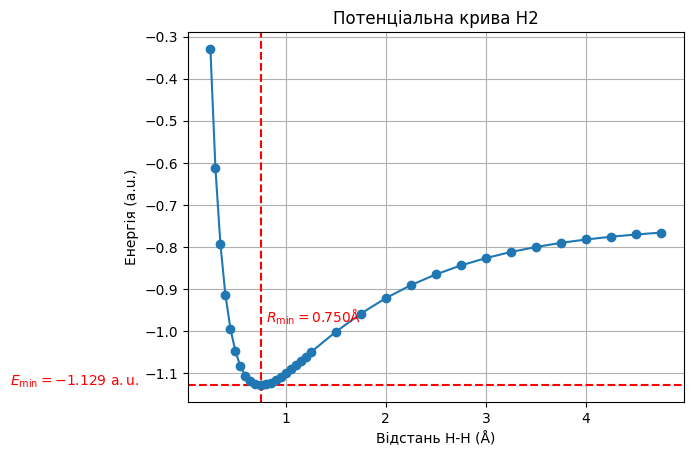

In [7]:
# точка мінімуму
plt.plot(R_min, E_min, 'ro', label="Minimum")  # червона точка

# штрихові лінії
plt.axvline(R_min, color='r', linestyle='--')  # вертикальна
plt.axhline(E_min, color='r', linestyle='--')  # горизонтальна

# написи біля ліній
plt.text(R_min - 2.5,
         E_min,
         rf'$E_{{\min}} = {E_min:.3f}\ \mathrm{{a.u.}}$',
         color='r')

plt.text(R[0]+0.55, 
         E_min + 0.15, 
         rf'$R_{{\min}}={R_min:.3f} \text{{Å}}$', 
         color='r')


# малюємо графік
plt.plot(R, E, marker="o")
plt.xlabel("Відстань H-H (Å)")
plt.ylabel("Енергія (a.u.)")
plt.title("Потенціальна крива H2")
plt.grid(True)
plt.show()

# Обчислені інтеграли те енергії для оптимальної геометрії

In [8]:
mol = gto.M(atom=f"H 0 0 0; H 0 0 0.741", basis=basis)

In [9]:
mf = scf.RHF(mol)
mf.kernel()
# Матриця густини
dm = mf.make_rdm1()

converged SCF energy = -1.12871101091532


# Розклад енергії молекули H₂

Повна енергія системи розкладається як:

$$
E_{\rm tot} = E_{\rm kin} + E_{\rm ne} + E_{\rm ee} + E_{\rm nn}
$$

де:  

- **Кінетична енергія електронів** $E_{\rm kin}$  

$$
E_{\rm kin} = \sum_{\mu\nu} D_{\mu\nu} \, T_{\mu\nu} = \mathrm{Tr}[D T]
$$

- **Потенціальна енергія електронів у полі ядер** $E_{\rm ne}$  

$$
E_{\rm ne} = \sum_{\mu\nu} D_{\mu\nu} \, V_{\mu\nu} = \mathrm{Tr}[D V]
$$

- **Електрон–електронна взаємодія** $E_{\rm ee}$  

$$
E_{\rm ee} = \frac{1}{2} \sum_{\mu\nu} D_{\mu\nu} \, V_{\mu\nu} = \frac{1}{2} \mathrm{Tr}[D V_{\rm eff}]
$$

- **Відштовхування ядер (ядро–ядро)** $E_{\rm nn}$  

$$
E_{\rm nn} = \sum_{A<B} \frac{Z_A Z_B}{|\mathbf{R}_A - \mathbf{R}_B|}
$$

---

### Пояснення символів:

- $D_{\mu\nu}$ — матриця густини електронів у базисі атомних орбіталей (AO).  
- $T_{\mu\nu}$ — матриця кінетичної енергії в AO-базисі.  
- $V_{\mu\nu}$ — матриця потенціальної енергії електронів у полі ядер.  
- $V_{\mu\nu}$ або $V_{\rm eff}$ — ефективний двоелектронний потенціал (кулон+обмін для H).  
- $Z_A, Z_B$ — заряди ядер A і B, $\mathbf{R}_A, \mathbf{R}_B$ — їхні координати.  
- $\mathrm{Tr}[\dots]$ — слід матриці (сума по діагоналі).  


In [10]:

# --- Інтеграли ---
T = mol.intor('int1e_kin')    # кінетична енергія
V = mol.intor('int1e_nuc')    # електрон-ядро

# ядро-ядро
E_nn = mol.energy_nuc()

# --- Обчислення компонентів ---
E_kin = np.einsum('ij,ji->', dm, T)     # Tr[D*T]
E_ne  = np.einsum('ij,ji->', dm, V)     # Tr[D*V]
vhf   = mf.get_veff(mol, dm)
E_ee  = 1/2 * np.einsum('ij,ji->', dm, vhf)  # ½ Tr[D*V_HF]

# --- Сумарна «ручна» енергія ---
E_tot_manual = E_kin + E_ne + E_ee + E_nn

# --- Вивід ---
print(f"Кінетична енергія: {E_kin:.6f} a.u.")
print(f"Електрон-ядро: {E_ne:.6f} a.u.")
print(f"Електрон-електрон: {E_ee:.6f} a.u.")
print(f"Ядро-ядро: {E_nn:.6f} a.u.")
print(f"Сума компонентів: {E_tot_manual:.6f} a.u.")
print(f"SCF total (mf.e_tot): {mf.e_tot:.6f} a.u.")
print(f"Різниця: {E_tot_manual - mf.e_tot:.2e} a.u.")

Кінетична енергія: 1.096280 a.u.
Електрон-ядро: -3.597763 a.u.
Електрон-електрон: 0.658633 a.u.
Ядро-ядро: 0.714139 a.u.
Сума компонентів: -1.128711 a.u.
SCF total (mf.e_tot): -1.128711 a.u.
Різниця: 4.44e-16 a.u.


# Сканування енергії методом Coupled Clusters

**Coupled Clusters (CC)** — це високоточний метод квантової хімії для обчислення енергій молекул, що враховує електронну кореляцію.  

## Основна ідея

У CC хвильова функція записується як експонента оператора збудження:

$$
|\Psi_{\rm CC}\rangle = e^{\hat{T}} |\Phi_0\rangle
$$

де:  
- $|\Phi_0\rangle$ — детермінант обчислений методом HF (Hartree-Fock),  
- $\hat{T} = \hat{T}_1 + \hat{T}_2 + \dots$ — оператор збудження (одиночні $\hat{T}_1$, подвійні $\hat{T}_2$ і т.д.).  

## CCSD як приклад

Мінімальна практична реалізація зазвичай включає:

- **CCSD** — Coupled Clusters з одиночними і подвійними збудженнями.
- Енергія CC визначається як:

$$
E_{\rm CC} = \langle \Phi_0 | e^{-\hat{T}} \hat{H} e^{\hat{T}} | \Phi_0 \rangle
$$

де $\hat{H}$ — гамільтоніан системи.  

## Переваги CC

- Висока точність (часто до **хімічної точності**, ~1 kcal/mol).  
- Коректний опис кореляції електронів.  

## Недоліки

- Висока обчислювальна складність: CCSD ~ \(O(N^6)\), CCSD(T) ~ \(O(N^7)\).  
- Потребує HF хвильову функцію як стартову.  

---

**Примітка:**  
CC методи широко використовуються для невеликих молекул або як еталон при порівнянні з менш точними методами (DFT, MP2).  


In [11]:
R = []
E = []

In [12]:
cc_scanner = gto.M(verbose=0).apply(scf.RHF).apply(cc.CCSD).as_scanner()
for r in distances:
    e = cc_scanner(gto.M(atom=f"H 0 0 0; H 0 0 {r}", basis=basis))
    R.append(r)
    E.append(e)

In [13]:
# індекс мінімальної енергії
idx_min = np.argmin(E)

# мінімальна енергія
E_min = E[idx_min]

# відстань, де мінімум
R_min = R[idx_min]

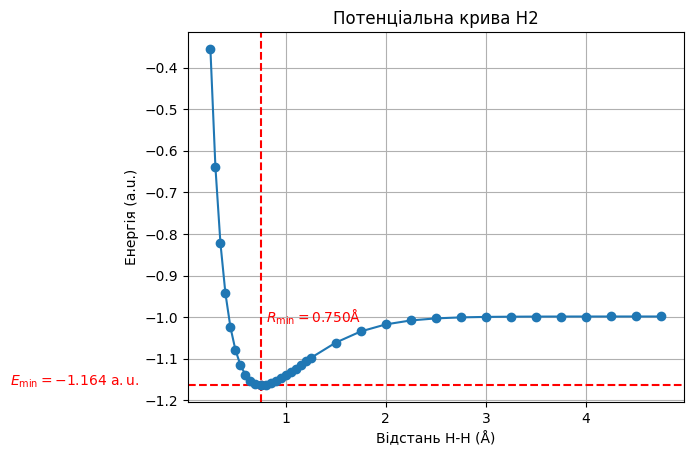

In [14]:
# точка мінімуму
plt.plot(R_min, E_min, 'ro', label="Minimum")  # червона точка

# штрихові лінії
plt.axvline(R_min, color='r', linestyle='--')  # вертикальна
plt.axhline(E_min, color='r', linestyle='--')  # горизонтальна

# написи біля ліній
plt.text(R_min - 2.5,
         E_min,
         rf'$E_{{\min}} = {E_min:.3f}\ \mathrm{{a.u.}}$',
         color='r')

plt.text(R[0]+0.55, 
         E_min + 0.15, 
         rf'$R_{{\min}}={R_min:.3f} \text{{Å}}$', 
         color='r')


# малюємо графік
plt.plot(R, E, marker="o")
plt.xlabel("Відстань H-H (Å)")
plt.ylabel("Енергія (a.u.)")
plt.title("Потенціальна крива H2")
plt.grid(True)
plt.show()